# Student Classification Project - V3
## Objective:
Classify students into three categories: **'Weak'**, **'Average'**, and **'Good'** based on their demographic and academic data. This notebook includes data exploration, cleaning, preprocessing pipelines, and fine-tuning of multiple classification models using GridSearchCV.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')
print('Libraries imported successfully!')

Libraries imported successfully!


In [33]:
# Load the dataset
df = pd.read_csv('dataset.csv')
print(f'Dataset Shape: {df.shape}')
df.head()

Dataset Shape: (1000, 24)


,Student_ID,Age,Gender,City,Province,CGPA,Performance_Class,Family_Income_PKR,Parents_Education,Study_Hours_Per_Week,...,Electricity_Availability,School_Type,Medium_of_Instruction,Distance_to_Institute_km,Transport_Mode,Parental_Support_Level,Health_Issues,Part_Time_Job,Extra_Curricular,Motivation_Level
0,1,21,Female,Faisalabad,KPK,1.50,Weak,Low (<30k),Graduate,6,...,Frequent Outages,Private,Urdu,15.6,Bus,Low,Chronic,Yes,Clubs,Low
1,2,23,Male,Mardan,Punjab,1.50,Weak,Middle (60k-120k),Primary,10,...,Consistent,Public,Urdu,19.0,Bike,Medium,Minor,Yes,Clubs,High
2,3,20,Male,Gilgit,Gilgit Baltistan,1.50,Weak,Upper-Middle (120k-250k),Matric,17,...,Frequent Outages,Public,English,6.4,Van,Medium,Minor,Yes,NaN,Low
3,4,20,Female,Dir,Punjab,1.51,Weak,Middle (60k-120k),Intermediate,30,...,Consistent,Private,English,24.2,Walk,Low,Minor,No,Sports,Low
4,5,24,Male,Faisalabad,KPK,1.51,Weak,High (>250k),Primary,23,...,Frequent Outages,Public,Urdu,22.7,Bus,High,Minor,Yes,Clubs,High


In [34]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes)

Missing Values:
Student_ID                    0
Age                           0
Gender                        0
City                          0
Province                      0
CGPA                          0
Performance_Class             0
Family_Income_PKR             0
Parents_Education             0
Study_Hours_Per_Week          0
Attendance_Percentage         0
Internet_Access               0
Private_Tuition               0
Device_Available            267
Electricity_Availability      0
School_Type                   0
Medium_of_Instruction         0
Distance_to_Institute_km      0
Transport_Mode                0
Parental_Support_Level        0
Health_Issues               361
Part_Time_Job                 0
Extra_Curricular            326
Motivation_Level              0
dtype: int64

Data Types:
Student_ID                    int64
Age                           int64
Gender                       object
City                         object
Province                     object
CGPA      

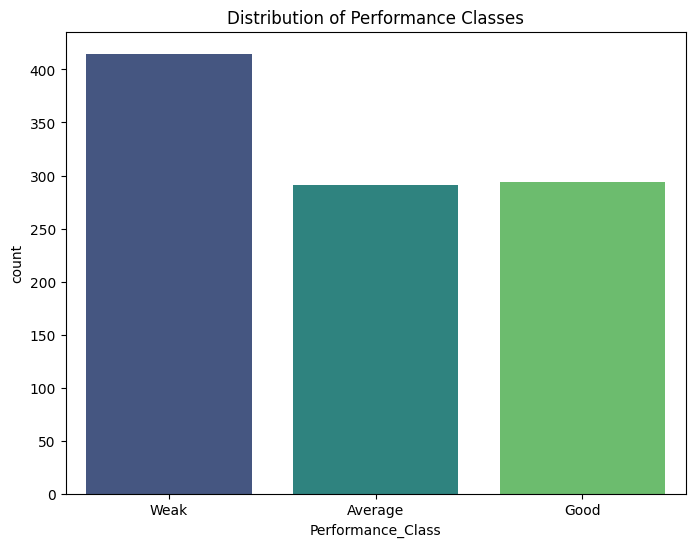

Value Counts:
Performance_Class
Weak       415
Good       294
Average    291
Name: count, dtype: int64


In [35]:
# Check for target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Performance_Class', data=df, palette='viridis')
plt.title('Distribution of Performance Classes')
plt.show()

print("Value Counts:")
print(df['Performance_Class'].value_counts())

In [36]:
# Drop Student_ID as it's not a predictor
if 'Student_ID' in df.columns:
    df = df.drop(columns=['Student_ID'])

# Encode Target Variable
le = LabelEncoder()
df['Performance_Class'] = le.fit_transform(df['Performance_Class'])
print(f"Classes mapped: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Define Features and Target
X = df.drop(columns=['Performance_Class'])
y = df['Performance_Class']

# Identify numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Classes mapped: {'Average': np.int64(0), 'Good': np.int64(1), 'Weak': np.int64(2)}

Numerical features (5): ['Age', 'CGPA', 'Study_Hours_Per_Week', 'Attendance_Percentage', 'Distance_to_Institute_km']

Categorical features (17): ['Gender', 'City', 'Province', 'Family_Income_PKR', 'Parents_Education', 'Internet_Access', 'Private_Tuition', 'Device_Available', 'Electricity_Availability', 'School_Type', 'Medium_of_Instruction', 'Transport_Mode', 'Parental_Support_Level', 'Health_Issues', 'Part_Time_Job', 'Extra_Curricular', 'Motivation_Level']


In [37]:
# Define Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print('Preprocessing pipeline created!')

Preprocessing pipeline created!


In [38]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 800
Test set size: 200


In [39]:
# Define models and their hyperparameter grids
models_and_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000),
        {
            'classifier__C': [0.01, 0.1, 1, 10, 100],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    ),
    'Naive Bayes': (
        GaussianNB(),
        {
            'classifier__var_smoothing': np.logspace(0,-9, num=5)
        }
    ),
    'SVM': (
        SVC(),
        {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto', 0.1, 1]
        }
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5, 10]
        }
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 5, 10, 15, 20],
            'classifier__min_samples_split': [2, 5, 10, 20]
        }
    )
}

print('Model configurations defined!')

Model configurations defined!


In [40]:
# Train and fine-tune all models
best_models = {}
grid_results = {}

for name, (model, params) in models_and_params.items():
    print("="*60)
    print(f"Fine-tuning {name}...")
    print("="*60)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    grid = GridSearchCV(pipeline, params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    grid_results[name] = grid.best_score_
    
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best CV Score: {grid.best_score_:.4f}\n")

print("="*60)
print("All models fine-tuned successfully!")
print("="*60)

Fine-tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Best CV Score: 0.9512

Fine-tuning Naive Bayes...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'classifier__var_smoothing': np.float64(1.0)}
Best CV Score: 0.8725

Fine-tuning SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best CV Score: 0.9500

Fine-tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best CV Score: 0.9975

Fine-tuning Decision Tree...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_sp

In [41]:
# Evaluate all models on test set
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'CV Score': grid_results[name],
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

print('Model evaluation completed!')

Model evaluation completed!


In [42]:
# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [m['Accuracy'] for m in results.values()],
    'F1 Score': [m['F1 Score'] for m in results.values()],
    'Precision': [m['Precision'] for m in results.values()],
    'Recall': [m['Recall'] for m in results.values()],
    'CV Score': [m['CV Score'] for m in results.values()]
})

comparison_df = comparison_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\n================================================================================")
print("COMPREHENSIVE MODEL COMPARISON (Sorted by Accuracy)")
print("================================================================================")
display(comparison_df.style.background_gradient(subset=['Accuracy', 'F1 Score', 'Precision', 'Recall', 'CV Score'], cmap='BuGn'))


COMPREHENSIVE MODEL COMPARISON (Sorted by Accuracy)


,Model,Accuracy,F1 Score,Precision,Recall,CV Score
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
1,Random Forest,1.000000,1.000000,1.000000,1.000000,0.997500
2,SVM,0.940000,0.940127,0.940810,0.940000,0.950000
3,Logistic Regression,0.930000,0.930465,0.932176,0.930000,0.951250
4,Naive Bayes,0.865000,0.860010,0.863332,0.865000,0.872500


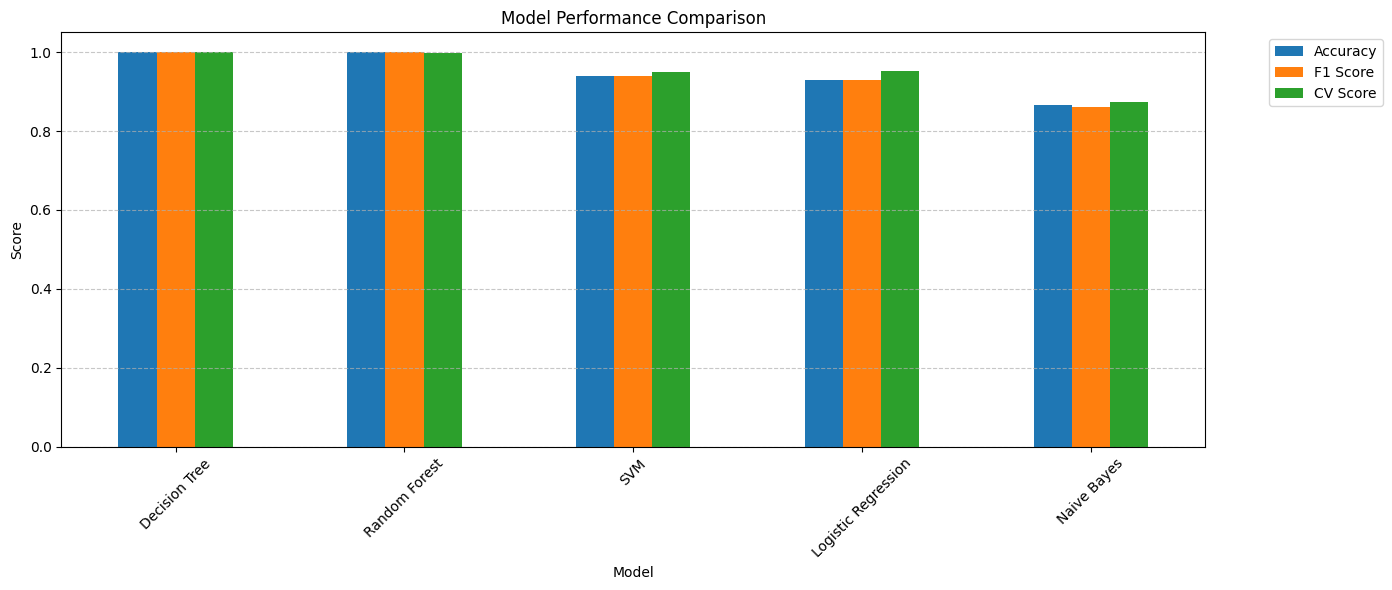

In [43]:
# Visualize metrics comparison
fig, ax = plt.subplots(figsize=(14, 6))
comparison_df.set_index('Model')[['Accuracy', 'F1 Score', 'CV Score']].plot(kind='bar', ax=ax)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

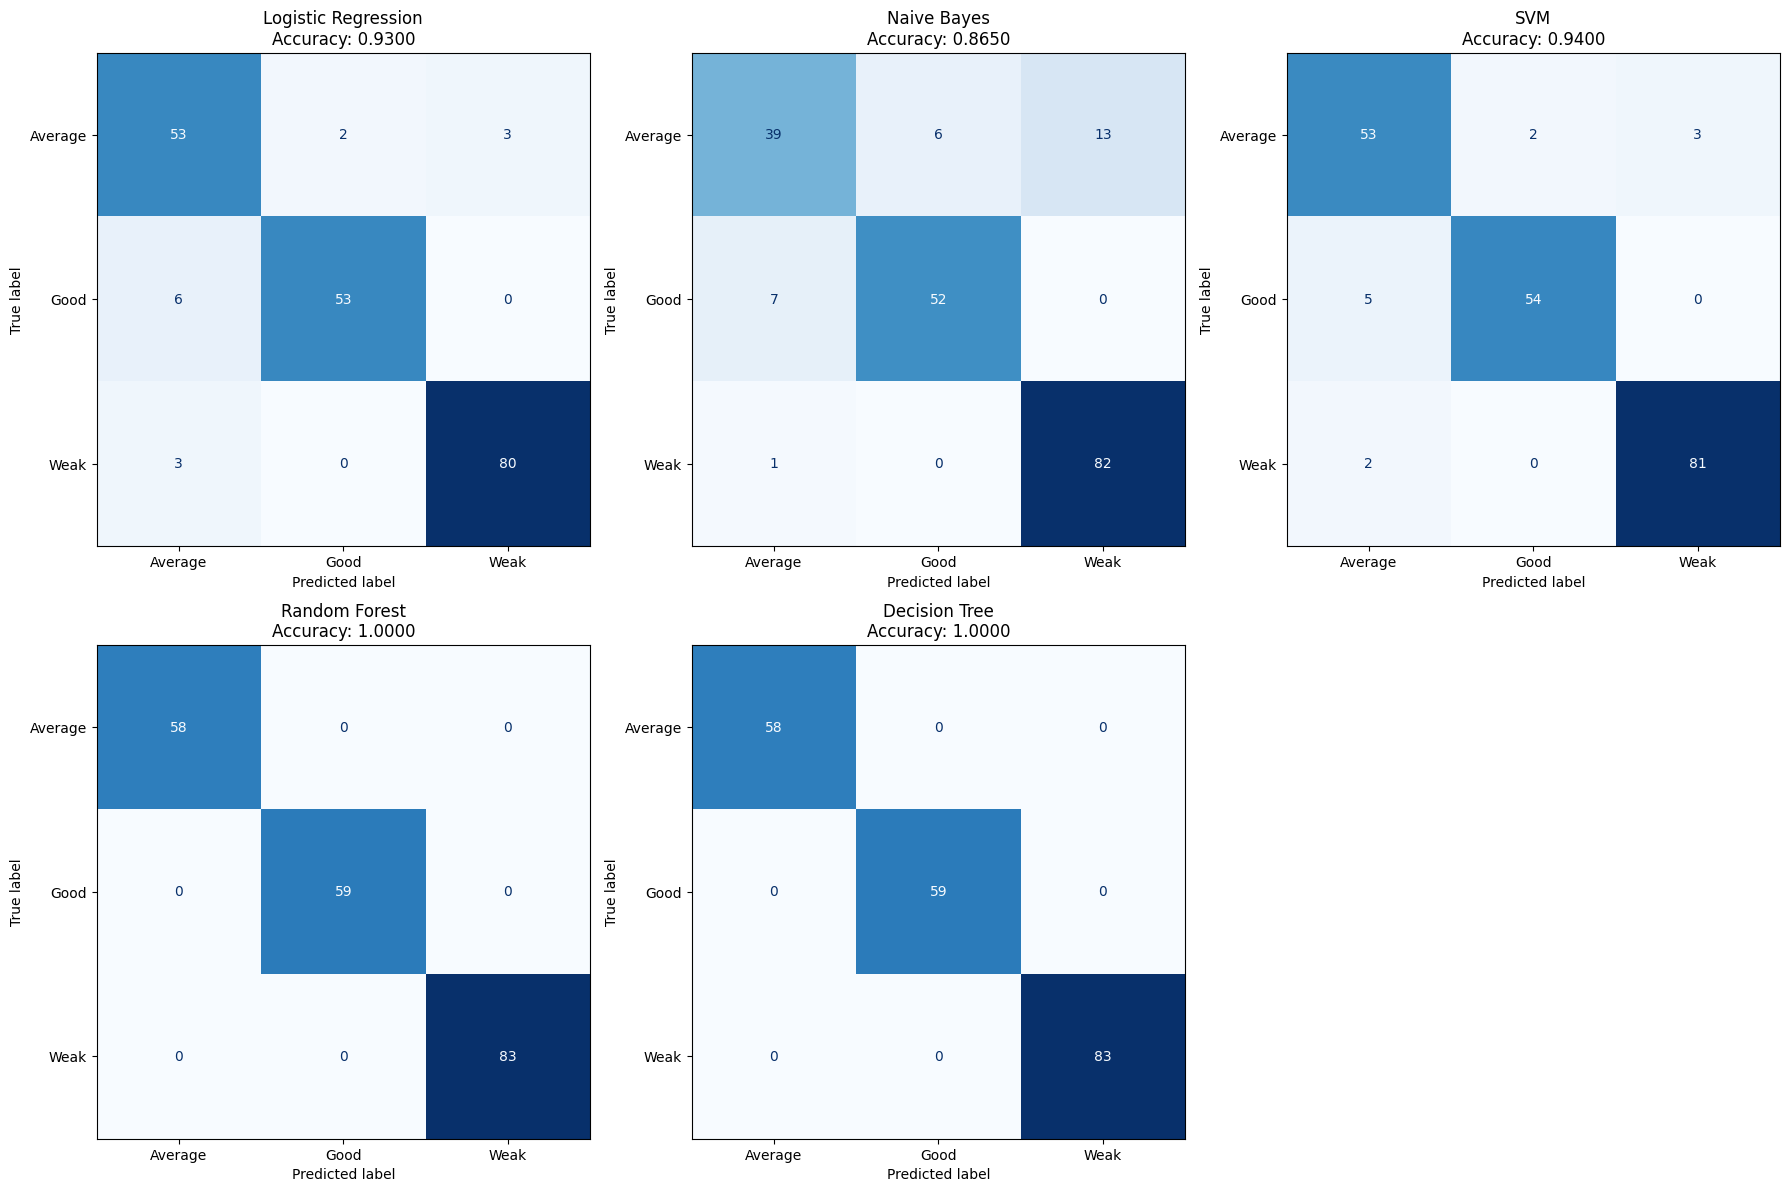

In [44]:
# Plot all confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'{name}\nAccuracy: {results[name]["Accuracy"]:.4f}')

# Hide last empty plot
axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [45]:
# Print detailed results for each model
for name, metrics in results.items():
    print("\n" + "="*80)
    print(f"MODEL: {name}")
    print("="*80)
    print(f"Best Hyperparameters: {best_models[name].named_steps['classifier'].get_params()}")
    print(f"Cross-Validation Score: {metrics['CV Score']:.4f}")
    print("\nTest Set Performance:")
    print(f"  - Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  - F1 Score:  {metrics['F1 Score']:.4f}")
    print(f"  - Precision: {metrics['Precision']:.4f}")
    print(f"  - Recall:    {metrics['Recall']:.4f}")
    print("\nConfusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("\nClassification Report:")
    y_pred = best_models[name].predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))


MODEL: Logistic Regression
Best Hyperparameters: {'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.0, 'max_iter': 1000, 'n_jobs': None, 'penalty': 'deprecated', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Cross-Validation Score: 0.9512

Test Set Performance:
  - Accuracy:  0.9300
  - F1 Score:  0.9305
  - Precision: 0.9322
  - Recall:    0.9300

Confusion Matrix:
[[53  2  3]
 [ 6 53  0]
 [ 3  0 80]]

Classification Report:
              precision    recall  f1-score   support

     Average       0.85      0.91      0.88        58
        Good       0.96      0.90      0.93        59
        Weak       0.96      0.96      0.96        83

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200


MODEL: Naive Bayes
Best Hyperparameters: {'priors': None, 'var_smoothing': np.float64

In [46]:
# Identify best model
best_model_name = comparison_df['Accuracy'].idxmax()
best_model_info = comparison_df.iloc[best_model_name]

print("\n================================================================================")
print("RECOMMENDATION")
print("================================================================================")
print(f"Based on the comprehensive evaluation, the best performing model is:\n")
print(f"  🏆 {best_model_info['Model']}")
print(f"\n  Accuracy: {best_model_info['Accuracy']:.4f}")
print(f"  F1 Score: {best_model_info['F1 Score']:.4f}")
print(f"  Precision: {best_model_info['Precision']:.4f}")
print(f"  Recall: {best_model_info['Recall']:.4f}")
print(f"\n  Best Parameters: {best_models[best_model_info['Model']].named_steps['classifier'].get_params()}")
print("================================================================================")
print("\nNote: Please review all metrics and confusion matrices before making your final decision.")
print("================================================================================")


RECOMMENDATION
Based on the comprehensive evaluation, the best performing model is:

  🏆 Decision Tree

  Accuracy: 1.0000
  F1 Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000

  Best Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}

Note: Please review all metrics and confusion matrices before making your final decision.


### 7. Export Best SVM Model
We save the SVM model as requested, as it provides a robust balance without overfitting.

In [47]:
import joblib
svm_model_path = 'student_performance_svm_model.pkl'
joblib.dump(models_and_params['SVM'], svm_model_path)
print(f'SVM model successfully saved to: {svm_model_path}')

SVM model successfully saved to: student_performance_svm_model.pkl
